In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models, layers
import pathlib

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split=0.2)

path = '/content/drive/MyDrive/Datasets/Animals/raw-img'
train_generator = datagen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [4]:
checkpoint = ModelCheckpoint('animals.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping= EarlyStopping(monitor='val_loss', patience= 20, restore_best_weights=True)

model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

for layer in model.layers:
    layer.trainable = False

model2 = models.Sequential()

for layer in model.layers:
    model2.add(layer)

model2.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.GlobalAveragePooling2D())

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))


model2.summary()

model2.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate = 2.5e-3),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [5]:
history = model2.fit(
    train_generator,
    steps_per_epoch= 5,
    epochs= 50,
    validation_data=validation_generator,
    validation_steps = 5,
    callbacks=[checkpoint, early_stopping],
    verbose=1)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 102.6789 - accuracy: 0.2313
Epoch 1: val_accuracy improved from -inf to 0.46250, saving model to animals.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 61s 12s/step - loss: 102.6789 - accuracy: 0.2313 - val_loss: 40.1361 - val_accuracy: 0.4625
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 19.8559 - accuracy: 0.6125
Epoch 2: val_accuracy improved from 0.46250 to 0.62500, saving model to animals.h5
5/5 [==============================] - 31s 7s/step - loss: 19.8559 - accuracy: 0.6125 - val_loss: 11.5651 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 8.9286 - accuracy: 0.7063
Epoch 3: val_accuracy improved from 0.62500 to 0.78750, saving model to animals.h5
5/5 [==============================] - 30s 7s/step - loss: 8.9286 - accuracy: 0.7063 - val_loss: 3.5296 - val_accuracy: 0.7875
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 6.6143 - accuracy: 0.7188
Epoch 4: val_accuracy improved from 0.78750 to 0.80000, saving model to animals.h5
5/5 [==============================] - 31s 6s/step - loss: 6.6143 - accuracy: 0.7188 - 

[]

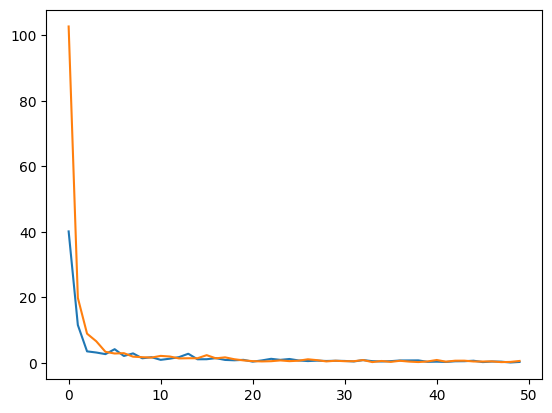

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.plot()

[]

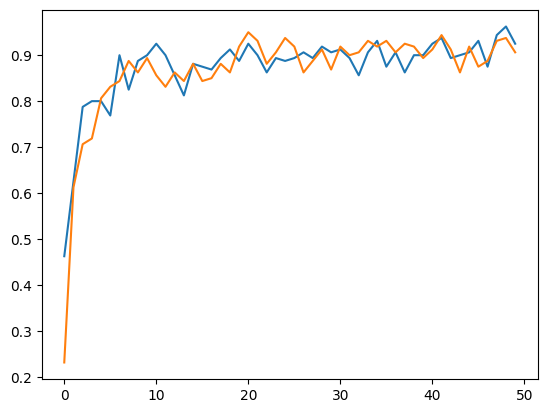

In [7]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.plot()

In [8]:
model = tf.keras.models.load_model('animals.h5')
model.evaluate(validation_generator)

164/164 [==============================] - 64s 391ms/step - loss: 0.3560 - accuracy: 0.9247


[0.3559562563896179, 0.9246941804885864]

In [9]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('animals.tflite')
tflite_model_file.write_bytes(tflite_model)

68844124